In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

In [2]:
from tda.experiments.mahalanobis.mahalanobis_binary import Config, run_experiment, evaluate_epsilon, \
    compute_means_and_sigmas_inv, get_config, logger
from tda.models.architectures import mnist_lenet, get_architecture, mnist_mlp
from tda.models.datasets import Dataset
from tda.models import get_deep_model

2020-01-20 11:40:23,487 - Devices - INFO - Found 0 compatible with CUDA


In [6]:
config = Config(
    # Number of epochs for the model
    epochs = 50,
    # Dataset we consider (MNIST, SVHN)
    dataset = "MNIST",
    # Name of the architecture
    architecture = mnist_lenet.name,
    # Size of the dataset used for the experiment
    dataset_size = 100,
    # Type of attack (FGSM, BIM, CW)
    attack_type = "FGSM",
    # Epsilon for the preprocessing step (see the paper)
    preproc_epsilon = 0.3,
    # Noise to consider for the noisy samples
    noise = 0.0,
    # Number of sample per class to estimate mu_class and sigma_class
    number_of_samples_for_mu_sigma = 100
)

In [7]:
dataset = Dataset(name=config.dataset)

architecture = get_deep_model(
    num_epochs=config.epochs,
    dataset=dataset,
    architecture=get_architecture(config.architecture),
    train_noise=0.0
)

mean_per_class, sigma_per_class_inv = compute_means_and_sigmas_inv(
    config=config,
    dataset=dataset,
    architecture=architecture
)

2020-01-20 11:41:24,474 - Models - INFO - Filename = /Users/t.ricatte/dev/tda_for_adv_robustness/tda/../trained_models/mnist_mnist_lenet_50_epochs.model 

/Users/t.ricatte/dev/tda_env/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'tda.models.architectures.Architecture' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
2020-01-20 11:41:24,502 - Models - INFO - Loaded successfully model from /Users/t.ricatte/dev/tda_for_adv_robustness/tda/../trained_models/mnist_mnist_lenet_50_epochs.model
2020-01-20 11:41:24,503 - Mahalanobis - INFO - I am going to go through a dataset of 100 points...
2020-01-20 11:41:24,572 - Mahalanobis - INFO - All indices for features are [-1, 0, 1, 2, 3, 4, 5, 6, 7]
2020-01-20 11:41:24,572 - Mahalanobis - INFO - All classes are [0, 1, 

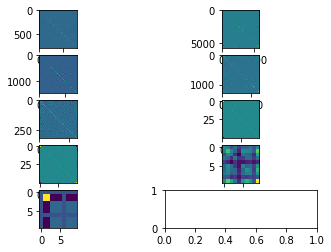

In [8]:
fig, axs = plt.subplots(len(sigma_per_class_inv)//2+1, 2)
i = 0

for layer_idx in sigma_per_class_inv:
    px = i // 2
    py = i % 2
    axs[px][py].imshow(sigma_per_class_inv[layer_idx])
    i+=1

In [9]:
aucs = dict()
coefs = dict()
for epsilon in [0.01, 0.025, 0.05, 0.1, 0.4]:
    auc, coef = evaluate_epsilon(
        config=config,
        epsilon=epsilon,
        dataset=dataset,
        architecture=architecture,
        mean_per_class=mean_per_class,
        sigma_per_class_inv=sigma_per_class_inv
    )
    
    logger.info(f"AUC for {epsilon} => {auc}")

    aucs[epsilon] = auc
    coefs[epsilon] = coef
    
logger.info(f"All AUCS are {aucs}")

2020-01-20 11:43:13,572 - Mahalanobis - INFO - All indices for features are [-1, 0, 1, 2, 3, 4, 5, 6, 7]
2020-01-20 11:43:13,573 - Mahalanobis - INFO - All classes are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2020-01-20 11:43:13,573 - Mahalanobis - INFO - Evaluating epsilon=0.01


RuntimeError: The size of tensor a (28) must match the size of tensor b (784) at non-singleton dimension 3

In [ ]:
evaluate_epsilon(
        config=config,
        epsilon=2,
        dataset=dataset,
        architecture=architecture,
        mean_per_class=mean_per_class,
        sigma_per_class_inv=sigma_per_class_inv
    )